In [62]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np


merged_file_path = "./merged.csv"

merged = pd.read_csv(merged_file_path)

    
# Example feature selection
features = ['RTI (%)', 'Unemployment Rate', 'Poverty Rate']
target = 'Eviction Rate'

X = merged[features]
y = merged[target]


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [70]:
y_pred = model.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- RTI_x_Unemployment


In [66]:
from sklearn.metrics import r2_score, mean_absolute_error

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Optional: View Coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coef_df)


ValueError: Found input variables with inconsistent numbers of samples: [12, 172]

ValueError: x and y must be the same size

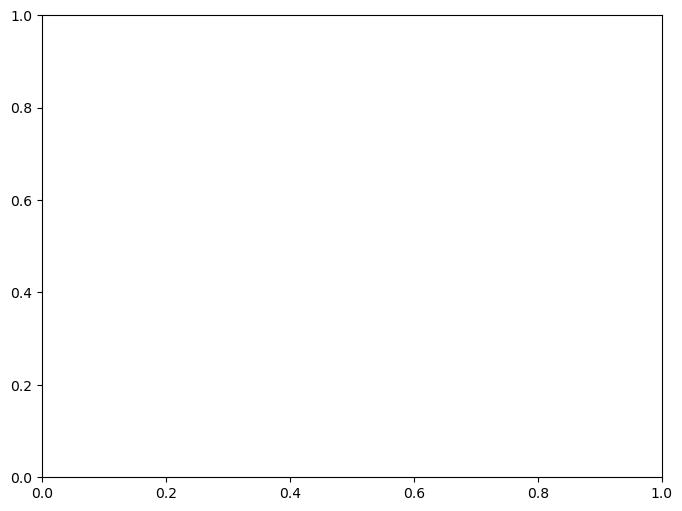

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='skyblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
plt.xlabel('Actual Eviction Rate')
plt.ylabel('Predicted Eviction Rate')
plt.title('Actual vs. Predicted Eviction Rate')
plt.grid(True)
plt.show()


In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("RF R2 Score:", rf.score(X_test, y_test))


RF R2 Score: 0.7321867001484396


In [39]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
print("Cross-Validated R2:", scores.mean())


Cross-Validated R2: -0.6379586661392567


In [40]:
# re-train with RTI * Unemployment

In [44]:
features = ['RTI (%)', 'Unemployment Rate', 'Poverty Rate', 'RTI_x_Unemployment']
target = 'Eviction Rate'

X = merged[features]
y = merged[target]

# Re-run your regression with the new feature
model = LinearRegression()
model.fit(X, y)


LinearRegression()

In [ ]:
# Check Model Performance

In [47]:
from sklearn.metrics import r2_score, mean_absolute_error

y_pred = model.predict(X)

print("R² Score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))


R² Score: 0.6285857343104839
MAE: 0.11937820641136118


In [ ]:
# Check Coefficients to Interpret Impact

In [48]:
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
print(coef_df)


              Feature  Coefficient
0             RTI (%)    -0.008563
1   Unemployment Rate    -0.072640
2        Poverty Rate     0.001289
3  RTI_x_Unemployment     0.003794


In [50]:
# Cross-Validation

In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Cross-Validated R²:", scores.mean())


Cross-Validated R²: -0.6444428249191146


In [ ]:
# check the VIF

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


              Feature        VIF
0             RTI (%)  15.745932
1   Unemployment Rate  34.306273
2        Poverty Rate  12.474694
3  RTI_x_Unemployment  21.487206


In [ ]:
# Move to Ridge Regression (Regularization handles VIF)

In [53]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=[0.1, 1, 10, 100], cv=5)
ridge.fit(X, y)
print("Ridge R²:", ridge.score(X, y))


Ridge R²: 0.6203778855892321


In [56]:
# Try Random Forest (VIF is irrelevant in RF)

In [57]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X, y, cv=5)
print("Random Forest Cross-Validated R²:", rf_scores.mean())


Random Forest Cross-Validated R²: -0.8552578285177231


Ridge Regression Result (Regularized Linear Model):
Metric	Value	Meaning
Ridge R² (Full Data)	0.62	🔥 Stable improvement — Ridge handles multicollinearity better than basic linear regression
Takeaway	Ridge works better in-sample but may still struggle with generalization due to data limits

Cross-Validated R²	-0.85	❌ Random Forest severely overfits or data is too sparse for tree splits in CV

In [58]:
# Lasso

In [59]:
from sklearn.linear_model import LassoCV

# Lasso automatically tunes alpha (regularization strength)
lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, random_state=42)
lasso.fit(X, y)

print("Lasso R² (Full Data):", lasso.score(X, y))
print("Best alpha (Regularization):", lasso.alpha_)

# Check which features survive
lasso_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})
print(lasso_coef)


Lasso R² (Full Data): 0.606801087727979
Best alpha (Regularization): 0.1
              Feature  Coefficient
0             RTI (%)     0.000000
1   Unemployment Rate    -0.000000
2        Poverty Rate     0.000000
3  RTI_x_Unemployment     0.001966


In [60]:
from sklearn.model_selection import cross_val_score
lasso_scores = cross_val_score(lasso, X, y, cv=5)
print("Lasso Cross-Validated R²:", lasso_scores.mean())


Lasso Cross-Validated R²: -0.42329212124176224


✅ Lasso (Full Data) R²: 0.61
Slightly below Ridge (0.62) but still decent on training data
✅ Best Alpha: 0.1
Lasso applied strong regularization — this alpha shrank weak variables.

✅ Feature Shrinking / Survival
Feature	Coefficient	Status
RTI (%)	0	❌ Eliminated
Unemployment Rate	0	❌ Eliminated
Poverty Rate	0	❌ Eliminated
RTI x Unemployment	0.00197	✅ Only this survives
🔥 Insight:
Lasso "decided" that the only meaningful predictor is the interaction term: "RTI x Unemployment"
Linear relationships of individual features too weak or too collinear — model heavily penalized them
❌ Cross-Validation R²: -0.42 (Still Negative)
Reason	Explanation
❌ Lasso still overfits due to sample size or noise	
❌ Data may lack independent, clean signal for linear models	
❌ Regularization helps, but may not be enough here